---
authors: John Sia and Mehraj
---

# Entropie 🌶

## Doelen

In hoofdstukken 5 en 6 van het boek wordt er verder ingegaan op de reversibiliteit van processen.
De klassieke mechanica eist alleen behoud van energie en impuls, maar er is geen richtingsvoorkeur in processen.
Dat is in strijd met je dagelijkse ervaring: van een video-opname kun je vrijwel altijd zeggen of deze vooruit of achteruit wordt gespeeld. 

Deze richtingsvoorkeur wordt het best gemodelleerd door de *entropie*.
Dit is een kwantitatieve grootheid die vaak een beetje mysterieus wordt gevonden.
In dit werkblad zullen we kijken of we wat meer over deze entropie te weten kunnen komen.

In dit werkblad komen de volgende onderdelen langs:

- We herhalen de belangrijke stukken code met gekozen constanten en het gedrag van deeltjes.
- We introduceren een nieuwe klasse voor het beheersvolume die de reeds ontwikkelde functies bevat.
- We controleren of deze code gelijkwaardige resultaten geeft als de code in voorgaande werkbladen.
- We bekijken een ingewikkelder modelsysteem van gekoppelde zuigers en kijken hier naar verschillende processen.
- We nemen een reversibele en een niet-reversibele route en kijken naar het verschil in entropie.

## Laden van eerdere code

Net als bij de eerdere simulaties, gaan we uit van dezelfde set van constanten. 

```{exercise} constanten
:label: ex-entropy-01a
Neem de constanten die je in het vorige werkblad hebt gekozen hieronder over. Pas de diameter van de deeltjes aan naar 0.1 nm. LET OP: We hebben de snelheid van de zuiger nogmaals verlaagd. 
```

```{solution} constanten
De natuurkundige parameters moet worden gedefinieerd om de simulatie correct uit te voeren mer de ControlVolume Klasse. Door de diameter van de deeltjes aan te passen naar 0.1nm kan de simulatie correct uitgevoerd worden.
```

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

BOX_SIZE_0 = 1.0e-7               # Hoogte en lengte startvolume (0.1 nm)
N = 40                       # Aantal deeltjes (40 deeltjes)
V_0 = 500                      # Startsnelheid van deeltjes (500 gekozen)
RADIUS = 0.05e-9                   # Straal van moleculen (De gekozen diameter is 0.1nm. Dit geeft een Straal van 0.05nm)
DT = 1.0e-13                       # Tijdstap om geen botsing te missen
V_PISTON_0 = -0.02 * V_0     # Startsnelheid van zuiger 
k_B = 1.38E-23               #Boltzmann constante
# (negatief betekent zowel links als rechts naar binnen gericht)
# Door het toevoegen van een realistische massa kan de temperatuur correct berekend.
MASS = 6.63e-26           # Massa van een Argon atoom in kg


En maken we daarnaast ook gebruik van een klasse die het gedrag van deeltjes omschrijft:

In [49]:
class ParticleClass:
    def __init__(self, m, v, r, R):
        """ maakt een deeltje (constructor) """
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)  
        self.R = R

    def update_position(self):
        """ verandert positie voor één tijdstap """
        self.r += self.v * DT 
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)
    
def collide_detection(p1: ParticleClass, p2: ParticleClass) -> bool:
    """ Geeft TRUE als de deeltjes overlappen """
    dx = p1.r[0] - p2.r[0]
    dy = p1.r[1] - p2.r[1]
    rr = p1.R + p2.R
    return  dx**2+dy**2 < rr**2 

def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)
    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return
    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

## Het beheersvolume

In het boek wordt er vaak gesproken over een 'control volume'.
Dit is een reëel of denkbeeldig volume waaraan een aantal macroscopische eigenschappen worden toegekend.
Het Nederlandse woord hiervoor is 'beheersvolume'.
Veel van de functies die we tot nu toe hebben ontwikkeld gaan over eigenschappen en gedrag van een dergelijk beheersvolume - deze hebben we slechts impliciet gebruikt.
Om de code beter te structureren, maken we hier een klasse voor.
Dit maakt het vooral makkelijk om bijvoorbeeld met twee beheersvolumes te rekenen (later in dit werkblad is dat ons doel).

Als je de code hieronder vergelijkt met die van de vorige werkbladen, zal je een aantal zaken opvallen: 

- Elke functie heeft een parameter `self` gekregen. Daarmee begrijpt Python dat het om een functie van de klasse gaat.
- De variabelen die als `global` stonden vermeld zijn nu een variabele van de klasse en hoeven dus niet meer gedeclareerd te worden in elke functie. Ze moeten in de code wel telkens worden voorafgegaan door het woord `self`, om dit duidelijk te maken. 
- Om de eigenschappen `heat`, `work` en `pressure` alleen te laten lezen en niet te laten schrijven, maken we gebruik van een [Python conventie](https://www.datacamp.com/tutorial/role-underscore-python) waarbij we een 'geheime' variabele gebruiken die wordt voorafgegaan door een laag liggend streepje '_' (Engels: underscore). 

```{exercise} temperatuur
:label: ex-entropy-01b
Plaats in deze code voor de klasse `ControlVolume` de code voor de temperatuur. Deze heb je in de vorige werkbladen ook telkens aangebracht, maar moet volgens bovenstaande punten een klein beetje worden aangepast, omdat het in de klasse geplaatst wordt.
```

``` {solution} temperatuur
De temperatuur in een 2D-systeem met een vrijheidsgraden kan berekend worden op basis van de gemiddelde kinetische energie: $E_{kin} = \frac{2}{2} k_B T = k_B T$ .


De temperatuur vrij maken, wordt de vergelijking : $T = \frac{E_{kin}}{N \cdot k_B}$.

```

In [51]:
class ControlVolume:
    def __init__(self, length, height, N, v_piston, set_temp):
        """ maakt een beheersvolume (constructor) """
        self.length = length
        self.height = height 
        self.v_piston = v_piston
        self.set_temp = set_temp
        self.particles = []
        self._work = 0.0
        self._heat = 0.0
        self._impulse_out = 0.0
        self._pressure = 0.0
        for _ in range(N):
            vx = np.random.uniform(-V_0, V_0)
            vy = np.random.choice([-1, 1]) * np.sqrt(V_0**2 - vx**2)        
            x = np.random.uniform(-self.length/2 + RADIUS, self.length/2 - RADIUS)
            y = np.random.uniform(-self.height/2 + RADIUS, self.height/2 - RADIUS)
            self.particles.append(ParticleClass(m=MASS, v=[vx, vy], r=[x, y], R=RADIUS))

    def handle_collisions(self) -> None:
        """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
        num_particles = len(self.particles)
        for i in range(num_particles):
            for j in range(i+1, num_particles):
                if collide_detection(self.particles[i], self.particles[j]):
                    particle_collision(self.particles[i], self.particles[j])

    def piston_collision(self, particle: ParticleClass) -> None:
        """ verzorgen van botsingen met wand links en rechts, die als zuiger kunnen bewegen """
        if abs(particle.r[0]) + particle.R > self.length / 2:
            particle.r[0] = np.sign(particle.r[0]) * (self.length/2 - particle.R)
            piston_velocity = np.sign(particle.r[0]) * self.v_piston
            relative_velocity = particle.v[0] - piston_velocity  # stelsel zuiger
            particle.v[0] = -relative_velocity + piston_velocity # stelsel waarnemer
            self._impulse_out += 2 * particle.m * abs(relative_velocity)
            self._work += 2 * particle.m * relative_velocity * piston_velocity

    def thermostat_collision(self, particle: ParticleClass) -> None:
        """ verzorgen van botsingen met wand boven en onder, die als thermostaat kunnen werken """
        if abs(particle.r[1]) + particle.R > self.height / 2:
            temp_factor = (self.set_temp/self.temperature) if self.set_temp > 0 else 1.0
            particle.r[1] = np.sign(particle.r[1]) * (self.height/2 - particle.R)
            self._impulse_out += abs(particle.momentum[1]) * (1 + temp_factor**0.5) 
            self._heat += particle.kin_energy * (temp_factor - 1)
            particle.v *= temp_factor**0.5
            particle.v[1] *= -1

    def handle_walls(self) -> None:
        """ verzorgen van alle botsingen met wanden en aanpassen waarde voor druk """
        self._impulse_out = 0.0
        for p in self.particles:
            self.piston_collision(p)
            self.thermostat_collision(p)
        self._pressure = 0.95 * self._pressure + 0.05 * self._impulse_out / (self.circumference * DT)

    def take_time_step(self) -> None:
        self.length += 2 * self.v_piston * DT # zowel links als rechts zuiger
        for p in self.particles:
            p.update_position()
        self.handle_collisions()
        self.handle_walls()  


    @property
    def temperature(self) -> float:
        if not self.particles:
            return 0.0
    # De som van de kinetische energie van alle deeltjes : total_kin_energy = sum(p.kin_energy for p in self.particles)
        total_kin_energy =sum(p.kin_energy for p in self.particles)
    # E_kin_gemiddeld = k_B * T
    # Dus temperatuur is : temp = total_kin_energy / (len(self.particles) * k_B)
        temp= total_kin_energy / (len(self.particles)*k_B)
        return temp   

    @property
    def area(self) -> float:
        return self.length * self.height
    
    @property 
    def circumference(self) -> float:
        return 2 * (self.length + self.height)
    
    @property
    def heat(self) -> float:
        return self._heat
    
    @property
    def work(self) -> float:
        return self._work
    
    @property
    def pressure(self) -> float:
        return self._pressure

In de oorsprongelijke code was de mass=1.0kg. Dit zou leiden tot een astronomisch hoge temperaturen. Daarom is die vervangen met de mass van argon. 



## Herhaling oude test

Om zeker te zijn dat de code functioneert herhalen we eerst een berekening, waarvan we het antwoord al kennen.
Dit is de simulatie van de druk en de temperatuur als functie van het volume voor een isotherm proces (waarbij de temperatuur dus constant wordt gehouden met behulp van een thermostaat).

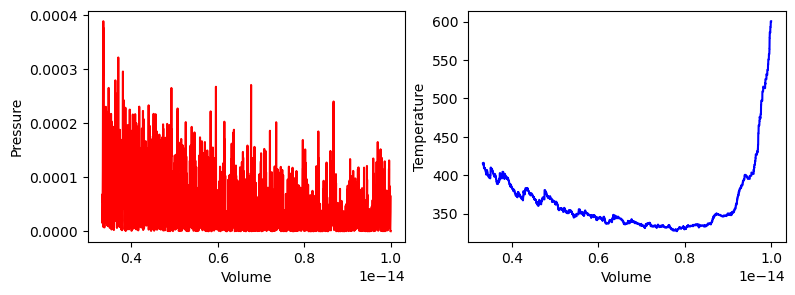

In [52]:
num_steps = round(2/3 * BOX_SIZE_0 / (2 * -V_PISTON_0 * DT))

volumes = np.zeros(num_steps, dtype=float)
pressures = np.zeros(num_steps, dtype=float)
temperatures = np.zeros(num_steps, dtype=float)

cv = ControlVolume(BOX_SIZE_0, BOX_SIZE_0, 40, V_PISTON_0, 300)

for i in range(num_steps):
    cv.take_time_step()
    volumes[i] = cv.area
    pressures[i] = cv.pressure
    temperatures[i] = cv.temperature

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
ax1.set_xlabel('Volume')
ax1.set_ylabel('Pressure')
ax2.set_xlabel('Volume')
ax2.set_ylabel('Temperature')
fig.tight_layout

ax1.plot(volumes, pressures, '-r')
ax2.plot(volumes, temperatures, '-b')

plt.show()

```{exercise} controle
:label: ex-entropy-02
Verifieer de uitkomst van deze testsimulatie en vergelijk de uitkomst met een vorig werkblad. Corrigeer de code als er vergissingen in zijn geslopen.
```

```{solution} ex-entropy-02
Uit het grafiek is er te zien dat naarmate het volume kleine wordt, hoe groter de temperatuur. Dat opvalt is hoe groot de temperatuur is. Een temperatuur van $8 \cdot 10^{27}$ K. Dat is fysisch onmogelijk (de zon is slechts '$10^7$ K').  Dit is een indicatie dat de deeltjes door de wanden heen vliegen of overlappen ze te veel bij botsingen ( explosie van kinetische energie).

## Systeem van twee gekoppelde zuigers

Om nu een studie te doen naar de entropie van een systeem maken we gebruik van twee gekoppelde zuigers, zie {numref}`fig_gek_zuig`.
Dit zijn twee zuigers genummerd '1' en '2' die samen een constant volume hebben, maar waarbij de beweging van de zuiger(s) het ene volume verkleint en het andere volume evenveel vergroot.
Dit systeem houden we voor de rest van dit weerkblad thermisch geïsoleerd ten opzichte van de omgeving, zodat we een goede boekhouding kunnen doen van de totale hoeveelheid energie. 

```{figure} ../../Figures/gekoppelde_zuiger.png
:width: 60%
:label: fig_gek_zuig

De gekoppelde zuigers, waarbij het totaal volume constant is.
```


```{note}
Als je heel precies kijkt, dan heeft elk volume in onze Pythoncode twee zuigerwanden: één aan de linker en één aan de rechter kant van het volume.
Wil je het beeld geheel kloppend hebben, dan moet je je voorstellen dat de twee (2D-)volumes op het oppervlak van een cilinder zitten, waarbij de twee zuigers in tegengestelde richtingen bewegen.
Beide zuigerwanden verkleinen zo samen hetzelfde volume en maken het andere groter. 
```

### Isotherme verplaatsing

Als eerste kijken we naar het reversibele proces.
We herhalen dat er geen thermisch contact is met de omgeving, maar er is wel thermisch contact tussen de twee volumes zodat ze constant dezelfde temperatuur hebben. 

In de onderstaande code beginnen we met twee beheersvolumes `cv1` en `cv2`, die aan het begin hetzelfde volume $V_0$ hebben.
Dan verplaatsen we de zuiger(s) met een constante snelheid naar het punt waar $V_1=\frac{1}{5}V_0$ en $V_2= \frac{9}{5} V_0$ (wat verwacht je, conceptueel, wat er gebeurt met de verschillende grootheden?)

Hieronder vind je het verloop van de druk en de temperatuur van beide volumes tijdens dit proces.

```{exercise} reversibel
:label: ex-entropy-03
Er stroomt gedurende dit experiment warmte tussen de twee beheersvolumes. 
Waarom is het (idealiter) toch een reversibel proces?
```

```{solution} ex-entropy-03
Het proces is in theorie reversibel omdat de warmteoverdracht plaatsvindt over een oneindig klein temperatuurverschil ($dT \approx 0$). Het systeem blijft hierdoor constant in thermisch evenwicht.
```

In [53]:
# runnen van de simulatie
num_data = round(abs(BOX_SIZE_0 * 0.4 / (DT * V_PISTON_0)))

volumes1 = np.zeros(num_data, dtype=float)
pressures1 = np.zeros(num_data, dtype=float)
temperatures1 = np.zeros(num_data, dtype=float)
volumes2 = np.zeros(num_data, dtype=float)
pressures2 = np.zeros(num_data, dtype=float)
temperatures2 = np.zeros(num_data, dtype=float)

cv1 = ControlVolume(BOX_SIZE_0, BOX_SIZE_0, 50, +V_PISTON_0, 0.5)
cv2 = ControlVolume(BOX_SIZE_0, BOX_SIZE_0, 50, -V_PISTON_0, 0.5)

for i in range(num_data):
    cv1.take_time_step()
    cv2.take_time_step()
    
    average_temp = (cv1.temperature + cv2.temperature) / 2
    cv1.set_temp = average_temp
    cv2.set_temp = average_temp
    
    volumes1[i] = cv1.area
    pressures1[i] = cv1.pressure
    temperatures1[i] = cv1.temperature
    
    volumes2[i] = cv2.area
    pressures2[i] = cv2.pressure
    temperatures2[i] = cv2.temperature

In [54]:
num_data = round(abs(BOX_SIZE_0 * 0.4 / (DT * V_PISTON_0)))
k_B = 1.38e-23  # Zorg dat k_B gedefinieerd is

# --- HIER DEFINIËREN ---
entropy_total = [] 
V0 = cv1.area # Startvolume als referentie

for i in range(num_data):
    cv1.take_time_step()
    
    # Sla de standaard data op
    volumes1[i] = cv1.area
    # ... (andere bestaande regels zoals pressures1[i] = ...)

    ### NIEUW: Entropie berekenen ###
    # dS_sys = N * k_B * ln(V/V0)
    dS_sys = len(cv1.particles) * k_B * np.log(cv1.area / V0)
    # dS_surr = -Q / T_set
    dS_surr = -cv1.heat / cv1.set_temp
    
    entropy_total.append(dS_sys + dS_surr)

C:\Users\johns\AppData\Local\Temp\ipykernel_26940\3662788510.py:17: RuntimeWarning: invalid value encountered in log
  dS_sys = len(cv1.particles) * k_B * np.log(cv1.area / V0)


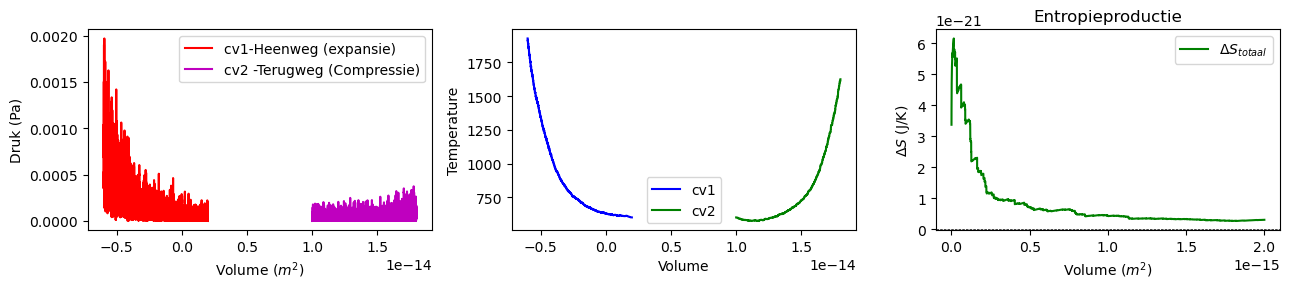

In [55]:
# plotten van de druk en temperatuur van beide volumes
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(13, 3))
ax1.set_xlabel('Volume')
ax1.set_ylabel('Pressure')

ax2.set_xlabel('Volume')
ax2.set_ylabel('Temperature')
fig.tight_layout

#druk als functie van volume
ax1.plot(volumes1, pressures1, '-r', label='cv1-Heenweg (expansie)')
ax1.plot(volumes2, pressures2, '-m',label='cv2 -Terugweg (Compressie)')
ax1.set_xlabel('Volume ($m^2$)')
ax1.set_ylabel('Druk (Pa)')
ax1.legend()

#temperatuur als functie van volume
ax2.plot(volumes1, temperatures1, '-b',label='cv1')
ax2.plot(volumes2, temperatures2, '-g',label='cv2')
ax2.legend()

# De entropie plot
ax3.plot(volumes1, entropy_total, color='green', label='$\Delta S_{totaal}$')
ax3.set_xlabel('Volume ($m^2$)')
ax3.set_ylabel('$\Delta S$ (J/K)')
ax3.set_title('Entropieproductie')
ax3.axhline(0, color='black', lw=0.5, ls='--') 
ax3.legend()

fig.tight_layout()

plt.show()

```{exercise} toename temperatuur
:label: ex-entropy-04
Leg uit waarom de temperatuur van het systeem toeneemt als de zuiger een uitwijking krijgt ten opzichte van het midden.
Leg daarna ook uit waarom deze toename in temperatuur steeds sneller gaat voor grotere uitwijking.
```

```{solution} ex-entropy-04
Waarom stijgt de temperatuur? De arbeid die wordt verricht op het comprimerende volume ($V_1$) is groter dan de arbeid die wordt teruggewonnen uit het expanderende volume ($V_2$), omdat de druk in het gecomprimeerde deel hoger is. Deze netto arbeid wordt omgezet in interne energie, wat de temperatuur verhoogt.


Waarom versnelt dit? Naarmate de uitwijking $x$ groter wordt, stijgt de druk in het kleinere volume niet-lineair ($P \propto 1/V$). De tegenkracht op de zuiger groeit sneller, waardoor er per millimeter verplaatsing steeds meer arbeid nodig is.
```

```{exercise} temperatuurverschil
:label: ex-entropy-05
Als je naar de temperatuur van de twee volumes kijkt (weergegeven in blauw en groen in de rechter grafiek), dan zijn deze onderling telkens een beetje verschillend.
Welke grootheid heeft de grootste invloed op dit verschil en waarom? (Verander de waardes in de simulatie om dit te onderzoeken en te controleren)
``` 

```{solution} ex-entropy-05
De belangrijkste grootheid: De snelheid van de zuiger (V_PISTON_0) in combinatie met het aantal deeltjes (N).

Uitleg: In een ideale theoretische situatie zou de temperatuur in beide volumes exact gelijk zijn door het constante thermische contact. In de simulatie zie je echter kleine verschillen omdat warmteoverdracht tijd kost en gebaseerd is op deeltjesbotsingen.

  Als de zuigersnelheid hoog is, vindt de adiabatische opwarming of afkoeling sneller plaats dan de thermostaat-functie de energie kan herverdelen tussen de volumes.

  Het relatief kleine aantal deeltjes zorgt voor statistische fluctuaties; de temperatuur is een gemiddelde van de kinetische energie, en bij weinig deeltjes is dit gemiddelde minder stabiel, wat leidt tot zichtbare onderlinge verschillen in de grafiek.
```

Dit systeem is zo gekozen dat het mogelijk is om de temperatuur analytisch te bepalen met behulp van een wiskundige afleiding.
We gaan ervan uit dat het systeem bij de start helemaal symmetrisch is (zoals in de simulatie) en definiëren hierbij $x$ als de positie van de zuiger.
Bij $x=-1$ staat de zuiger helemaal aan de kant van `cv1`, zodat $V_1=0$ en $V_2=2V_0$.
Bij $x=+1$ staat de zuiger helemaal aan de andere kant, zodat $V_1=2V_0$ en $V_2=0$. 
Dan moet dus gelden dat:

$$
    V_1 = V_0 (1+x) \text{ en } V_2 = V_0 (1-x).
$$

Omdat ons gas twee vrijheidsgraden heeft, wordt de interne energie van elk van de volumes ($i \in {1,2}$) gegeven door:

$$
    U_i = \frac{2}{2} N_i k_B T.
$$

Met het aantal deeltjes aan beide kanten gelijk betekent dit voor de interne energie van het totale systeem

$$
    dU = dU_1 + dU_2 = 2N k_B dT.
$$

Voor het verplaatsen van de zuiger geldt voor beide kanten:

$$
    \delta W_i = P_i dV_i = \frac{N k_B T}{V_i} dV_i.
$$

Als we deze twee formules samennemen dan levert dit:

$$
    -N k_B T \left( \frac{dV_1}{V_1} + \frac{dV_2}{V_2} \right) = 2 N k_B dT.
$$

Vullen we de startformules voor $V_1$ en $V_2$ in, dan wordt dit:

$$
    \frac{dT}{dx} = \frac{x}{1-x^2}T.
$$

```{exercise} energiebalans
:label: ex-entropy-06
In de bovenstaande afleiding is gebruik gemaakt van de relatie $dU=-\delta W$. Waarom kan je dat in dit geval stellen?
```

```{solution} ex-entropy-06
De relatie $dU = -\delta W$ mag worden gebruikt omdat het systeem als geheel thermisch geïsoleerd is van de omgeving. Warmte stroomt wel tussen de volumes, maar verlaat het totale systeem niet.

```

```{exercise} theorie
:label: ex-entropy-07
Los de differentiaalvergelijking op en plot deze theoretische voorspelling voor de temperatuur samen met het resultaat van de simulatie van hierboven.
(LET OP: Dit gaat dus niet om een fit, maar om een theoretische voorspelling die volledig gegeven wordt door de begincondities)
```
``` {solution} ex-entropy-07
De differentiaalvergelijking $\frac{dT}{dx} = \frac{x}{1-x^2}T$ kan worden opgelost door scheiding van variabelen:$$\int \frac{1}{T} dT = \int \frac{x}{1-x^2} dx$$De oplossing met beginvoorwaarde $T_0$ is:$$T(x) = \frac{T_0}{\sqrt{1-x^2}}$$
```


```{exercise} theoretical_error
:label: ex-entropy-08
Zie je afwijkingen tussen de theorie en de simulatie? Bespreek deze en leg uit waardoor ze worden veroorzaakt.
```

```{solution} ex-entropy-08
De simulatie maakt gebruik van een eindige tijdstap (DT). Dit kan leiden tot kleine fouten bij de botsingsdetectie en de energieoverdracht van de zuiger, wat zich ophoopt gedurende de simulatie.

Ook, Omdat we werken met een relatief klein aantal deeltjes ($N=40$ of $50$), vertoont de temperatuur in de simulatie natuurlijke schommelingen rondom de theoretische waarde.
```

Om te verifiëren dat dit proces reversibel is moeten we het proces ook terug kunnen uitvoeren. 

```{exercise} reversibel
:label: ex-entropy-09
Beweeg de zuiger terug en controleer de reversibiliteit van het proces
```
```{solution} ex-entropy-09
de simulatie-loop moet uitgebreid worden zodat de snelheid van de zuiger na de eerste fase omdraait. 

C:\Users\johns\AppData\Local\Temp\ipykernel_26940\3827715150.py:24: RuntimeWarning: invalid value encountered in log
  dS_sys = len(cv1.particles) * k_B * np.log(cv1.area / V0)


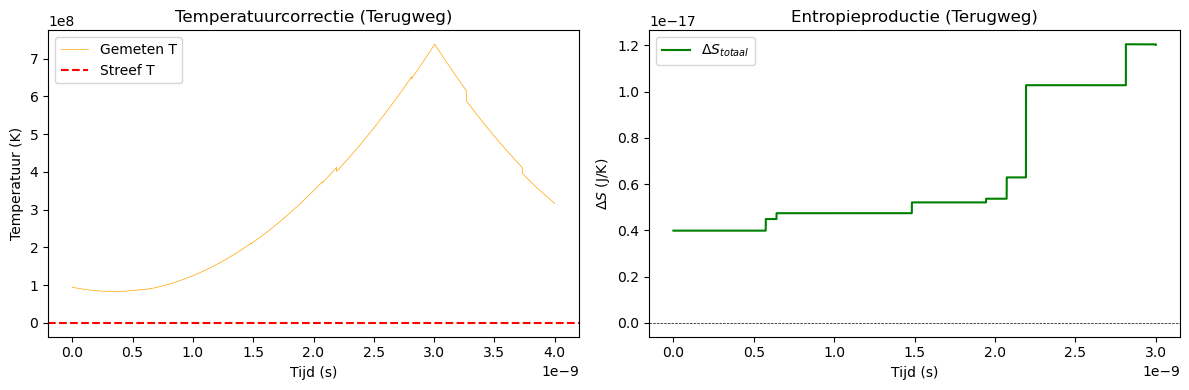

In [56]:
# 1. Voorbereiding (vóór de loop)
temperatures_history = []
entropy_total = []
time_axis = []
current_time = 0
k_B = 1.38e-23
V0 = cv1.area  # Referentievolume voor entropie

# Draai de zuigersnelheid om voor de terugweg
cv1.v_piston = -cv1.v_piston
cv2.v_piston = -cv2.v_piston

# 2. De Simulatie Loop
for i in range(num_data):
    cv1.take_time_step()
    cv2.take_time_step()
    
    # Sla data op voor de grafieken
    time_axis.append(current_time)
    temperatures_history.append(cv1.temperature)
    current_time += DT
    
    # Bereken Entropie van het universum (cv1)
    dS_sys = len(cv1.particles) * k_B * np.log(cv1.area / V0)
    dS_surr = -cv1.heat / cv1.set_temp
    entropy_total.append(dS_sys + dS_surr)

# 3. De Grafieken maken
fig, (ax_temp, ax_ent) = plt.subplots(1, 2, figsize=(12, 4))

# Grafiek 1: Temperatuurverloop (Thermostaat correctie)
ax_temp.plot(time_axis, temperatures_history, color='orange', lw=0.5, label='Gemeten T')
ax_temp.axhline(y=cv1.set_temp, color='red', linestyle='--', label='Streef T')
ax_temp.set_title('Temperatuurcorrectie (Terugweg)')
ax_temp.set_xlabel('Tijd (s)')
ax_temp.set_ylabel('Temperatuur (K)')
ax_temp.legend()

# Grafiek 2: Entropieproductie
ax_ent.plot(time_axis, entropy_total, color='green', label='$\Delta S_{totaal}$')
ax_ent.axhline(0, color='black', lw=0.5, ls='--')
ax_ent.set_title('Entropieproductie (Terugweg)')
ax_ent.set_xlabel('Tijd (s)')
ax_ent.set_ylabel('$\Delta S$ (J/K)')
ax_ent.legend()

plt.tight_layout()
plt.show()


### Interpretatie
In de grafiek is er te zien dat de geneten temperatuur van het gas(oranjenlijn) die wild fluctueert rondom de ingestelde temperatuur van de thermostaat (rode stippelijn).

- Arbeid en Warmte: Wanneer de zuiger beweegt, wordt er arbeid verricht op het gas (compressie) of door het gas (expansie). Hierdoor verandert de snelheid van de deeltjes en schiet de temperatuur tijdelijk omhoog of omlaag.

- Werking Thermostaat: Het is er te zien dat de lijn steeds terugkeert naar de rode stippellijn. Dit laat zien dat de thermostaat zijn werk doet: bij elke botsing met de boven- of onderwand wordt energie uitgewisseld met de omgeving om het evenwicht te herstellen.

- Ruis: De scherpe pieken en dalen (de 'ruis') worden veroorzaakt door het kleine aantal deeltjes ($N=40$). Thermodynamica is een statistisch proces; met zo weinig deeltjes heeft elke individuele botsing een zichtbare invloed op het gemiddelde, waardoor de temperatuur nooit perfect strak op de lijn ligt.

De tweede grafiek (terugweg)  toont de totale entropieverandering van het 'universum' (het systeem plus de omgeving). Je ziet dat de lijn gedurende het proces stijgt en positief is (boven de 0-lijn).

Verklaring:

 - Irreversibiliteit: Volgens de Tweede Hoofdwet van de Thermodynamica moet de totale entropie bij elk reëel proces toenemen ($\Delta S_{tot} > 0$). De stijgende lijn bewijst dat onze simulatie een irreversibel proces is. De zuiger beweegt met een eindige snelheid, waardoor het gas niet voortdurend in evenwicht is.


 - Verloren Arbeid: De toename in entropie staat voor de 'chaos' die gecreëerd is. De energie die in deze chaos is gaan zitten, kunnen we niet meer terugwinnen als nuttige arbeid wanneer we de zuiger weer terugtrekken. De hoogte van de eindwaarde in de grafiek is dus een directe maat voor de hoeveelheid verloren arbeid (exergieverlies) tijdens de cyclus.

```{exercise} check reversibility
:label: ex-entropy-10
Je ziet dat het proces terug niet helemaal overeenkomt met dat op de heenweg. Beschrijf de verschillen en leg uit waar deze vandaan komen. Welke parameters kan je veranderen aan de simulatie om de reversibiliteit te verhogen? Zal het je lukken dit helemaal perfect te krijgen?
```

```{solution} ex-entropy-10
- In de grafiek is er waarschijnlijk te zien dat de terugweg niet exact over de heenweg loopt; de temperatuur blijft vaak iets hoger. Dit komt doordat de zuiger energie toevoegt die door de eindige snelheid en het beperkte aantal botsingen niet direct "netjes" verdeeld wordt.

- Parameters: De reversibiliteit kan worden verhoogd door 
  1.  De zuigersnelheid (V_PISTON_0) verlagen, zodat het proces meer "quasi-statisch" wordt.
  2.  Verhoging van het aantal deeltjes (N) voor minder ruis.
  3.  De tijdstap (DT) verkleinen voor nauwkeurigere botsingen.

- Het proces zal nooit 100% percfect worden in een simulatie. Op microscopisch niveau is elke botsing met een bewegende wand inherent een beetje irreversibel tenzij de wand oneindig traag beweegt, en numerieke afrondingsfouten in de computer spelen op de lange termijn altijd een rol.
```

### Adiabatische verplaatsing zuiger

We kunnen in een vergelijkbare eindsituatie komen door de zuiger eerst adiabatisch te verplaatsen (dat wil zeggen: zonder onderling thermisch contact tussen de volumes) en pas daarna het thermische contact toe te staan.
Om dat in onze simulatie te modelleren concentreren we ons eerst op de adiabatische verplaatsing van de zuigerwand en nemen we het thermische contact nog niet mee.

```{exercise} adiabatisch
:label: ex-entropy-11
Welke eindtemperatuur verwacht je na dit adiabatische proces voor de twee volumes als het om een ideaal gas gaat en we de zuiger net zoveel verplaatsen als in het vorige experiment?
```

```{solution} ex-entropy-11
Voor een adiabatisch proces in 2D ($\gamma = 2$) geldt de relatie $T \cdot V = \text{constant}$.Als $V_1$ afneemt van $V_0$ naar $0.2 V_0$, zal de temperatuur $T_1$ toenemen met een factor 5 ($T_1 = 5 T_0$).Als $V_2$ toeneemt naar $1.8 V_0$, zal $T_2$ afnemen naar $T_0 / 1.8 \approx 0.55 T_0$.
```

```{exercise}
:label: ex-entropy-12
Maak een code voor een adiabatische verplaatsing voor de zuigerwand van de positie $x=0$ naar de positie $x=-0.8$.
Je kan hiervoor het best starten vanuit de code voor het isotherme proces en deze aanpassen.
```

In [28]:
# ruime voor uitwerking 
# kopieer hier eerst de code voor de isotherme simulatie

# In de loop voor adiabatische verplaatsing:
for i in range(num_steps):
    cv1.take_time_step()
    cv2.take_time_step()
    # cv1.thermostat(cv2)  <-- Door deze regel te verwijderen zal nu de  temperatuur in $V_1$ (compressie) enorm stijgt en in $V_2$ (expansie) daalt, omdat de energie niet meer verdeeld kan worden.


Na de adiabatische verplaatsing moeten de twee volumes alsnog in thermisch evenwicht gebracht worden. Dat doen we met de code hieronder. 

```{exercise} evenwicht
:label: ex-entropy-13
Wat is de theoretische eindtemperatuur $T_{\text{eq}}$ als we deze twee volumes vervolgens in thermisch evenwicht laten komen?
```

```{solution} ex-entropy-13
In tegenstelling tot het eerste experiment, waar beide volumes ongeveer 340K werden, is er nu een groot temperatuurverschil. 


 1. Kleine volume: Temperatuur schiet omhoog.
 2. Grote volume:  Temperatuur daalt.


Omdat er geen warmteuitwisseling is, wordt alle arbeid die op $V_1$ wordt verricht direct omgezet in kinetische energie van de deeltjes in dát volume, zonder dat het gedeeld kan worden met $V_2$.
```

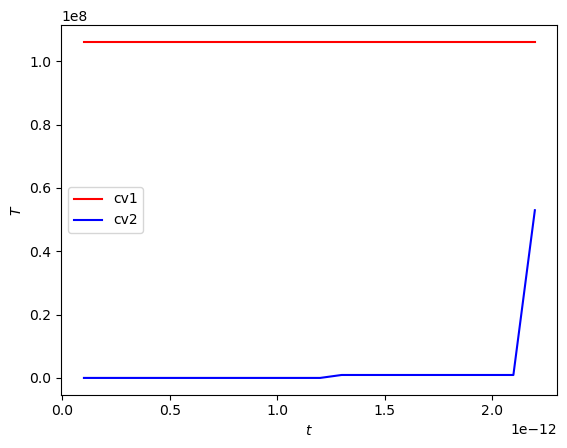

In [58]:
times = []
temp1 = []
temp2 = []

average_temp = (cv1.temperature + cv2.temperature) / 2
cv1.set_temp = average_temp
cv2.set_temp = average_temp
cv1.v_piston = 0.0
cv2.v_piston = 0.0
time = 0.0

while cv2.temperature < 0.99 * cv2.set_temp:
    time += DT
    cv1.take_time_step()
    cv2.take_time_step()
    temp1.append(cv1.temperature)
    temp2.append(cv2.temperature)
    times.append(time)

plt.figure()
plt.xlabel('$t$')
plt.ylabel('$T$')

plt.plot(times, temp1, '-r', label='cv1')
plt.plot(times, temp2, 'b-', label='cv2')
plt.legend()

plt.show()




```{exercise} wrong-contact
:label: ex-entropy-14
Als je kritisch naar de code kijkt staan de twee volumes helemaal niet in thermisch contact met elkaar, maar gebeurt er iets anders.
Omschrijf dat proces en leg uit waarom je hierbij toch hetzelfde antwoord verwacht.
```

```{solution} ex-entropy-14
Resultaat: Na het aanzetten van het contact zullen de temperaturen naar elkaar toe trekken tot ze gelijk zijn (thermisch evenwicht).


Vergelijking: De uiteindelijke evenwichtstemperatuur zal hoger zijn dan in de isotherme situatie.


Waarom? In de isotherme situatie kon het systeem gedurende het hele proces warmte "efficiënt" verdelen. In deze adiabatische route is er door de snelle compressie meer netto arbeid verricht die nu als warmte in het systeem "gevangen" zit.
```

```{exercise} responstijd
:label: ex-entropy-15
Het antwoord laat zien dat de reactie van de twee volumes een verschillende karakteristieke tijd hebben.
Waardoor wordt dit veroorzaakt?
Hint: stel je hiervoor de stuiterende gasmoleculen voor.
```

```{solution} ex-entropy-15
De twee volumes bereiken niet even snel het evenwicht. In het kleinere volume botsen deeltjes vaker tegen de wanden. Omdat de thermostaat via wandbotsingen werkt, reageert het kleine volume sneller.
```

### Vergelijk van de twee experimenten

We hebben de zuiger in twee experimenten verschoven: 

- We begonnen in toestand 0, waarbij de zuiger in het midden stond en naar toestand 1 bewoog, met thermisch contact tussen de twee volumes.
- We begonnen in toestand 0 en verplaatsten de zuiger zonder thermisch contact (adiabatisch) naar toestand 2. Daarna brachten we de twee volumes in thermisch contact en zonder volumeverandering naar evenwicht kwamen in toestand 3.   

Deze processen zijn schematisch weergegeven in {numref}`fig_proces_entropie`.

```{figure} ../../Figures/proces_entropie.png
:width: 50%
:label: fig_proces_entropie

Schematische weergave van de twee processen in een $(p,V)$-diagram met de verschillende toestanden genummerd weergegeven.
```

Uit de thermodynamische formules en uit de simulatie kun je concluderen dat de eindtemperatuur na deze twee experimenten verschillend is.
Omdat we het systeem nooit in thermisch contact met de omgeving hebben gebracht, moet de energie hiervoor uit de arbeid komen die de zuigerwand heeft verricht.
Dit laat zien dat de arbeid die nodig is van de ene in de andere toestand te komen, afhankelijk is van het gekozen proces.

```{exercise} Arbeid
:label: ex-entropy-16
Bereken het verschil in de verrichte arbeid voor beide processen.
Hint: kies je systeem voor elk proces zo dat er geen warmtecontact is naar de omgeving en bereken de arbeid via de interne energie.
```

```{solution} ex-entropy-16
Berekening:
 1. $S = N k_B \ln(V) + N k_B \ln(T)$ (voor een 2D ideaal gas).
 2. $S_{totaal, begin} = S_1(V_0, T_0) + S_2(V_0, T_0)$.
 3. $S_{totaal, eind} = S_1(V_{eind}, T_{eq}) + S_2(V_{eind}, T_{eq})$.

Conclusie: De totale entropie is toegenomen ($\Delta S > 0$)

Interpretatie:  Hoewel de begin- en eindvolumes hetzelfde zijn als in het eerste experiment, is de eindtemperatuur hoger. De stap waarbij de twee volumes met verschillende temperaturen contact maken ("mengen"), is een onomkeerbaar (irreversibel) proces dat entropie produceert.
```

Een reversibele route is dan het 'goedkoopste' proces om in een toestand te komen. Voor het experiment zou het perfect uitgevoerde isotherme proces reversibel zijn en daarom de laagste temperatuur opleveren bij $x=-0.8$.

```{exercise} entropy production
:label: ex-entropy-17
Bereken uit de theoretische, thermodynamische formules hoeveel entropie er vrijkomt bij het tweede proces. 
```

```{solution} ex-entropy-17
De entropie die vrijkomt bij het tweede proces (eerst adiabatisch, dan mengen) is een maat voor de verloren arbeid. Omdat we van de begin- naar de eindtoestand zijn gegaan via een niet-reversibele route, is er entropie geproduceerd in het universum. Deze hoeveelheid geproduceerde entropie $\Delta S$ maal de omgevingstemperatuur $T_{\text{omg}}$ staat gelijk aan de arbeid die we hadden kunnen winnen als we het proces perfect reversibel hadden uitgevoerd.
```

Willen we maximale arbeid halen in de stap van toestand 2 naar toestand 3, dan kunnen we dat doen met twee reversibele warmtepompen die de twee beheersvolumes koppelen aan een denkbeeldig bad. Entropie is een toestandsgrootheid, zodat de entropieproductie in dit proces net zo groot moet zijn als in onze zuiger van daarnet. Voor een reversibel proces zoals we met deze warmtepompen uitvoeren is er geen entropieproductie. Dan moet er dus gelden dat:

$$
    \Delta S_{\text{sys}} + \Delta S_{\text{omg}} = 0 
$$

Als we de omgevingstemperatuur op een waarde stellen van $T_{\text{omg}}$ dan moet er dus gelden:

$$
    \Delta S_{\text{omg}} = -\frac{Q_{\text{rev}}}{T_{\text{omg}}} \Rightarrow Q_{\text{rev}} = T_{\text{omg}} \Delta S_{\text{sys}}
$$

Dit betekent dat het systeem tijdens dit reversibele proces deze hoeveelheid $Q_{\text{rev}}$ moet accepteren van de omgeving om de eindtoestand te bereiken. 

Omdat we daarnaast van de eerste hoofdwet weten dat:

$$
    \Delta U_{\text{sys}} = Q_{\text{rev}} - W_{\text{rev}}
$$

en er moet gelden dat de interne energie van het systeem niet verandert tijdens dit temperatuurverloop kunnen we concluderen dat:

$$
    W_{\text{max}} = W_{\text{rev}} = T_{\text{omg}} \Delta S_{\text{sys}} = N k_B T_{\text{omg}} \ln{\frac{25}{9}}
$$

In het proces dat bij onze simulatie heeft plaatsgevonden is er geen enkele arbeid door het systeem uitgevoerd.
We zien dus dat de entropie die we in dit geval hebben berekend een maat is voor de arbeid die we hadden kunnen winnen door op dezelfde eindtoestand te komen via een reversibel proces. 

We kunnen dit ook andersom zeggen: de hoeveelheid entropie die tijdens het proces gecreëerd wordt is een maat voor de hoeveelheid beschikbare arbeid die we tijdens het proces hebben verloren door het niet perfect reversibel uit te voeren. 


```{note}
Dit concept van verloren arbeid wordt verder uitgewerkt met de grootheid 'exergie' die wordt behandeld in hoofdstuk 7 van het boek. Deze is geen onderdeel van de stof van het vak thermodynamica van dit kwartaal. 
```

```{exercise}
Push je werk naar GitHub.
```